# T7 - Calibration

We saw in Tutorial 4 how to load and plot data. But the next step is to actually *calibrate* the model to the data, i.e. find the model parameters that are the most likely explanation for the observed data. This tutorial gives an introduction to the Fit object and some recipes for optimization approaches.

<div class="alert alert-info">
    
Click [here](https://mybinder.org/v2/gh/institutefordiseasemodeling/covasim/HEAD?urlpath=lab%2Ftree%2Fdocs%2Ftutorials%2Ftut_calibration.ipynb) to open an interactive version of this notebook.
    
</div>

## The Fit object

The Fit object is responsible for quantifying how well a given model run matches the data. Let's consider a simple example, building on Tutorial 4:

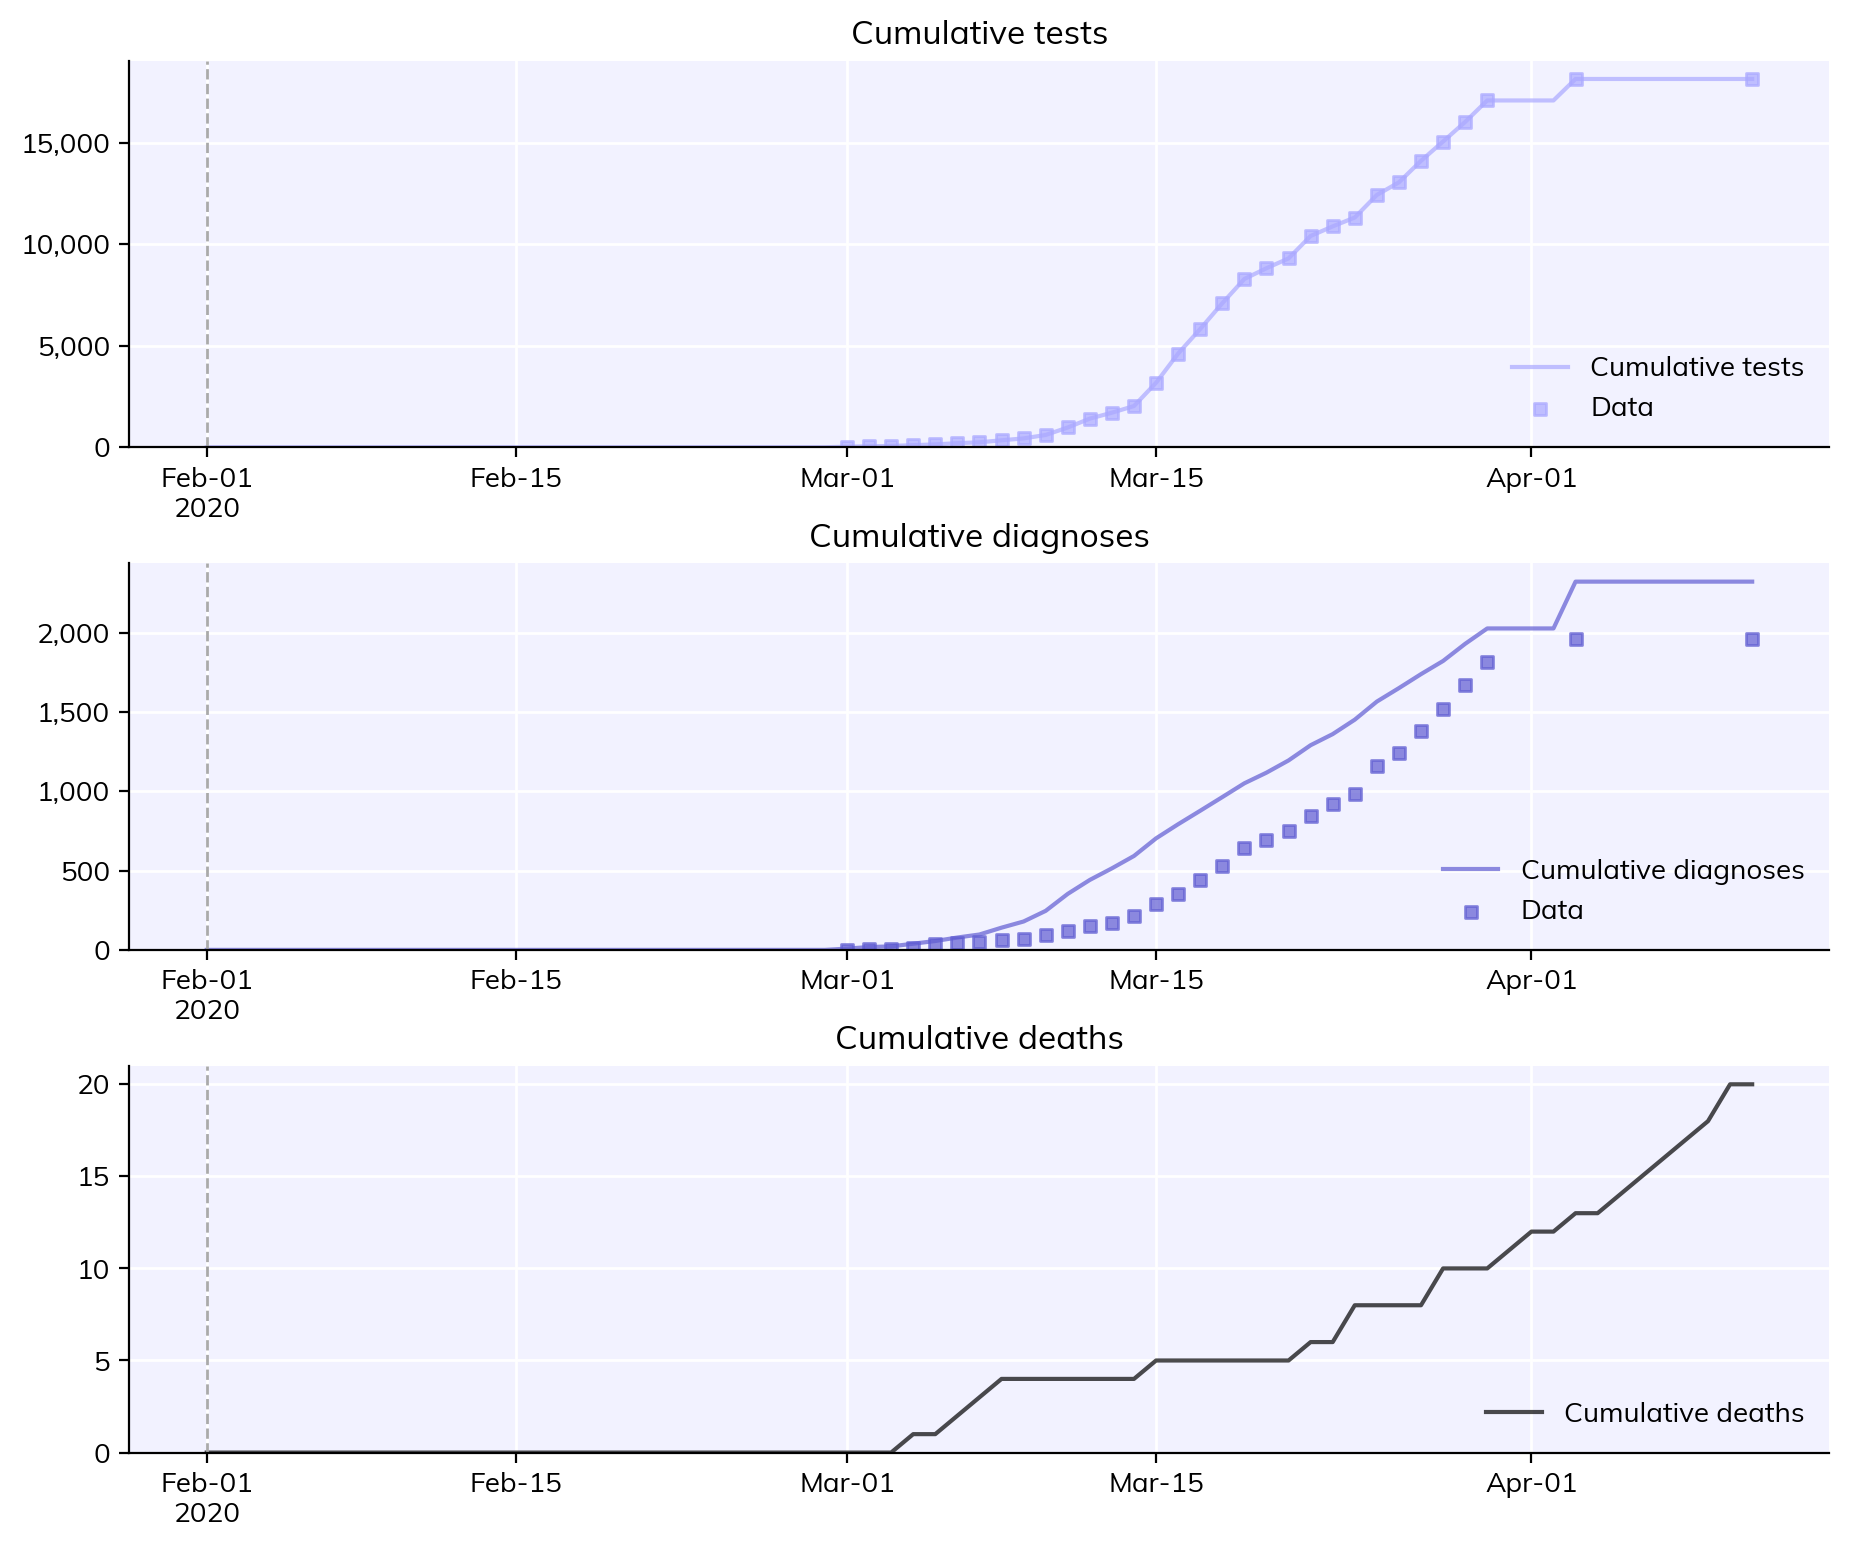

In [6]:
import covasim as cv
cv.options(jupyter=True, verbose=0)

pars = dict(
    pop_size  = 20000,
    start_day = '2020-02-01',
    end_day   = '2020-04-11',
)
sim = cv.Sim(pars=pars, datafile='example_data.csv', interventions=cv.test_num(daily_tests='data'))
sim.run()
sim.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths'])

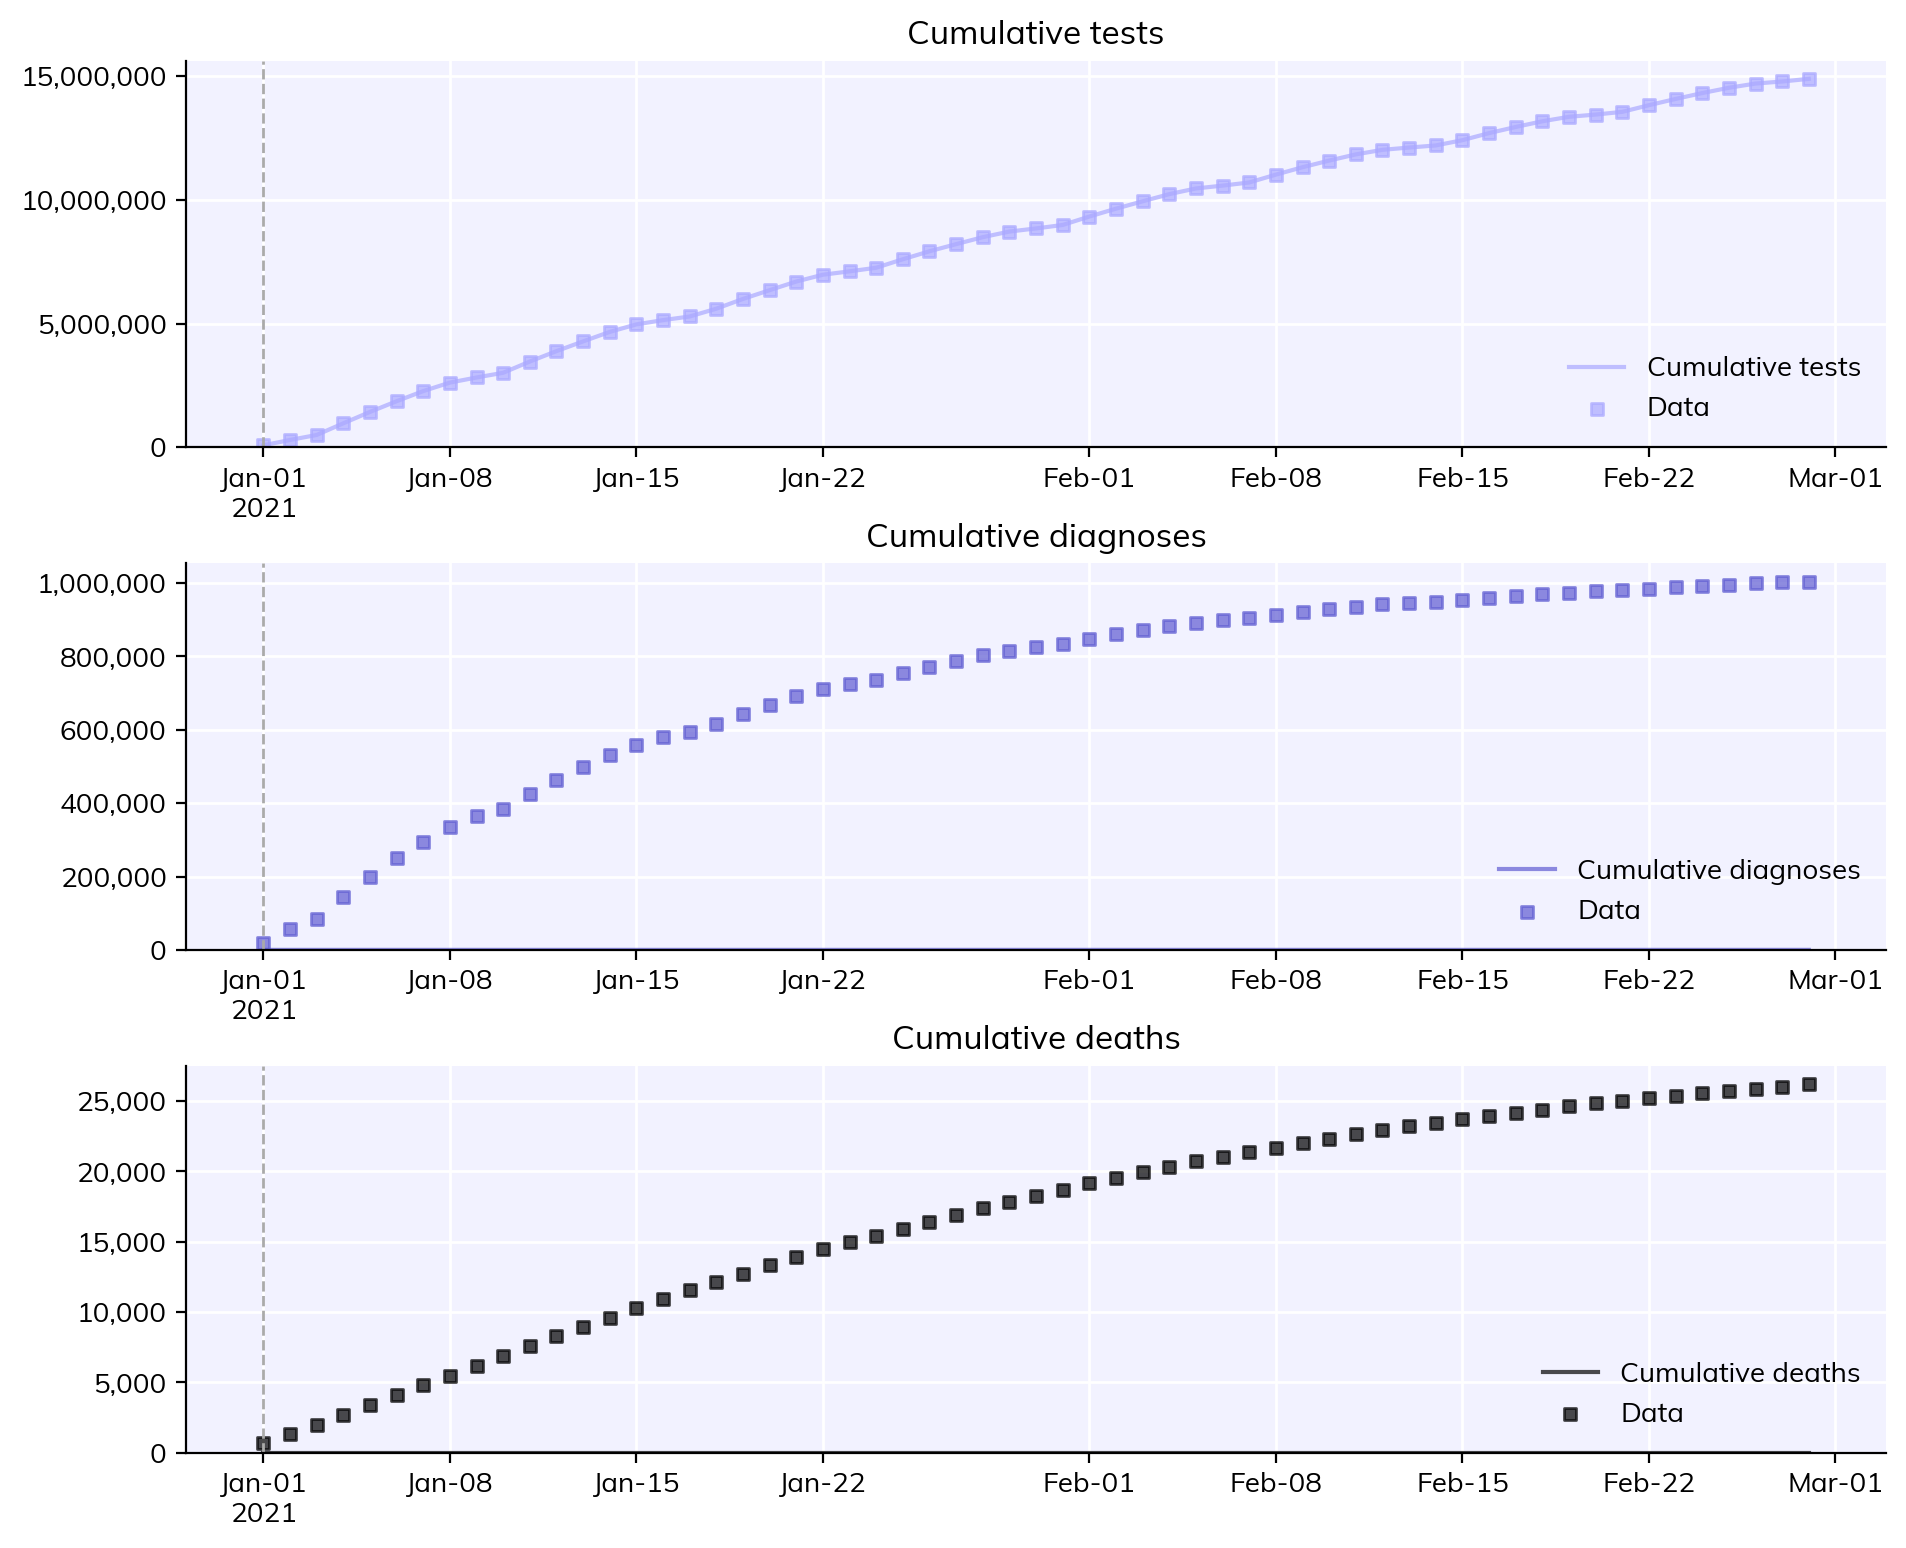

In [7]:
#My run with California data - ignore for now

import covasim as cv
cv.options(jupyter=True, verbose=0)

pars = dict(
    pop_size  = 200000,
    start_day = '2021-01-01',
    end_day   = '2021-02-28',
)
sim = cv.Sim(pars=pars, datafile='california_data.csv', interventions=cv.test_num(daily_tests='data'))
sim.run()
sim.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths'])

We can see that tests match extremely well (they're input data!), diagnoses match reasonably well, and deaths match poorly. Can the Fit object capture our intuition about this?

In [3]:
fit = sim.compute_fit()
fit.summarize()

Mismatch values for:
#0. 'cum_deaths':    55.65217391304348
#1. 'cum_tests':     0.0
#2. 'cum_diagnoses': 22.428498467824312

Total mismatch value:
78.08067238086778


So the results seem to match our intuition. (Note that by default the Fit object uses normalized absolute difference, but other estimates, such as mean squared error, are also possible.)

What if we improve the fit? Does the mismatch reduce?

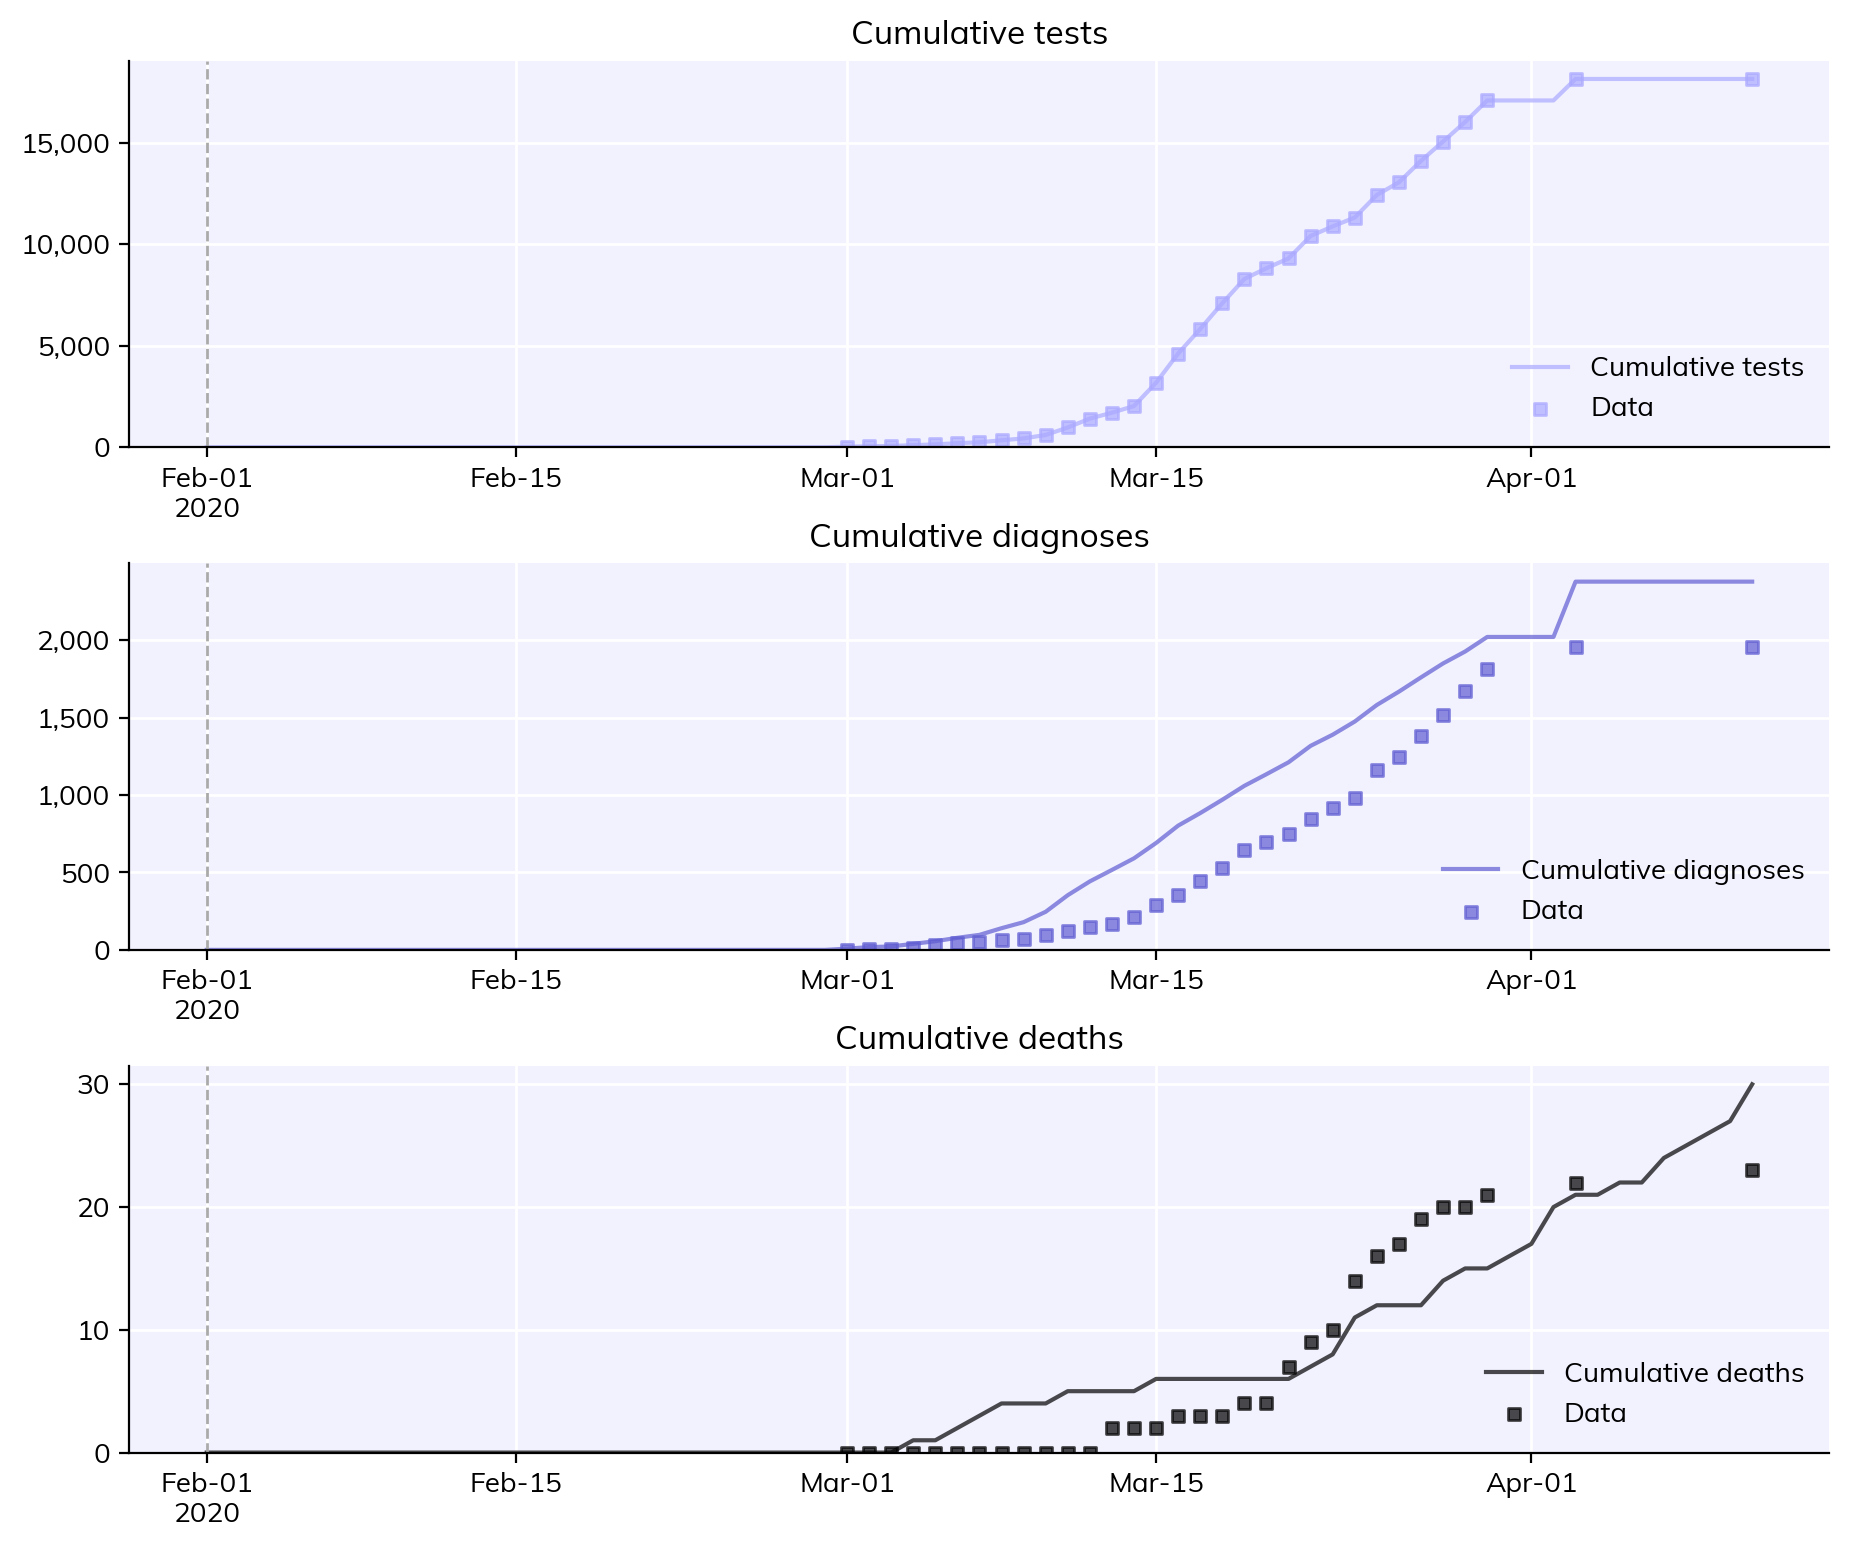

In [4]:
sim['rel_death_prob'] = 2 # Increase the death rate since deaths were too low
sim.initialize(reset=True) # Reinitialize the sim

# Rerun and compute fit
sim.run()
fit = sim.compute_fit()

# Output
sim.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths'])

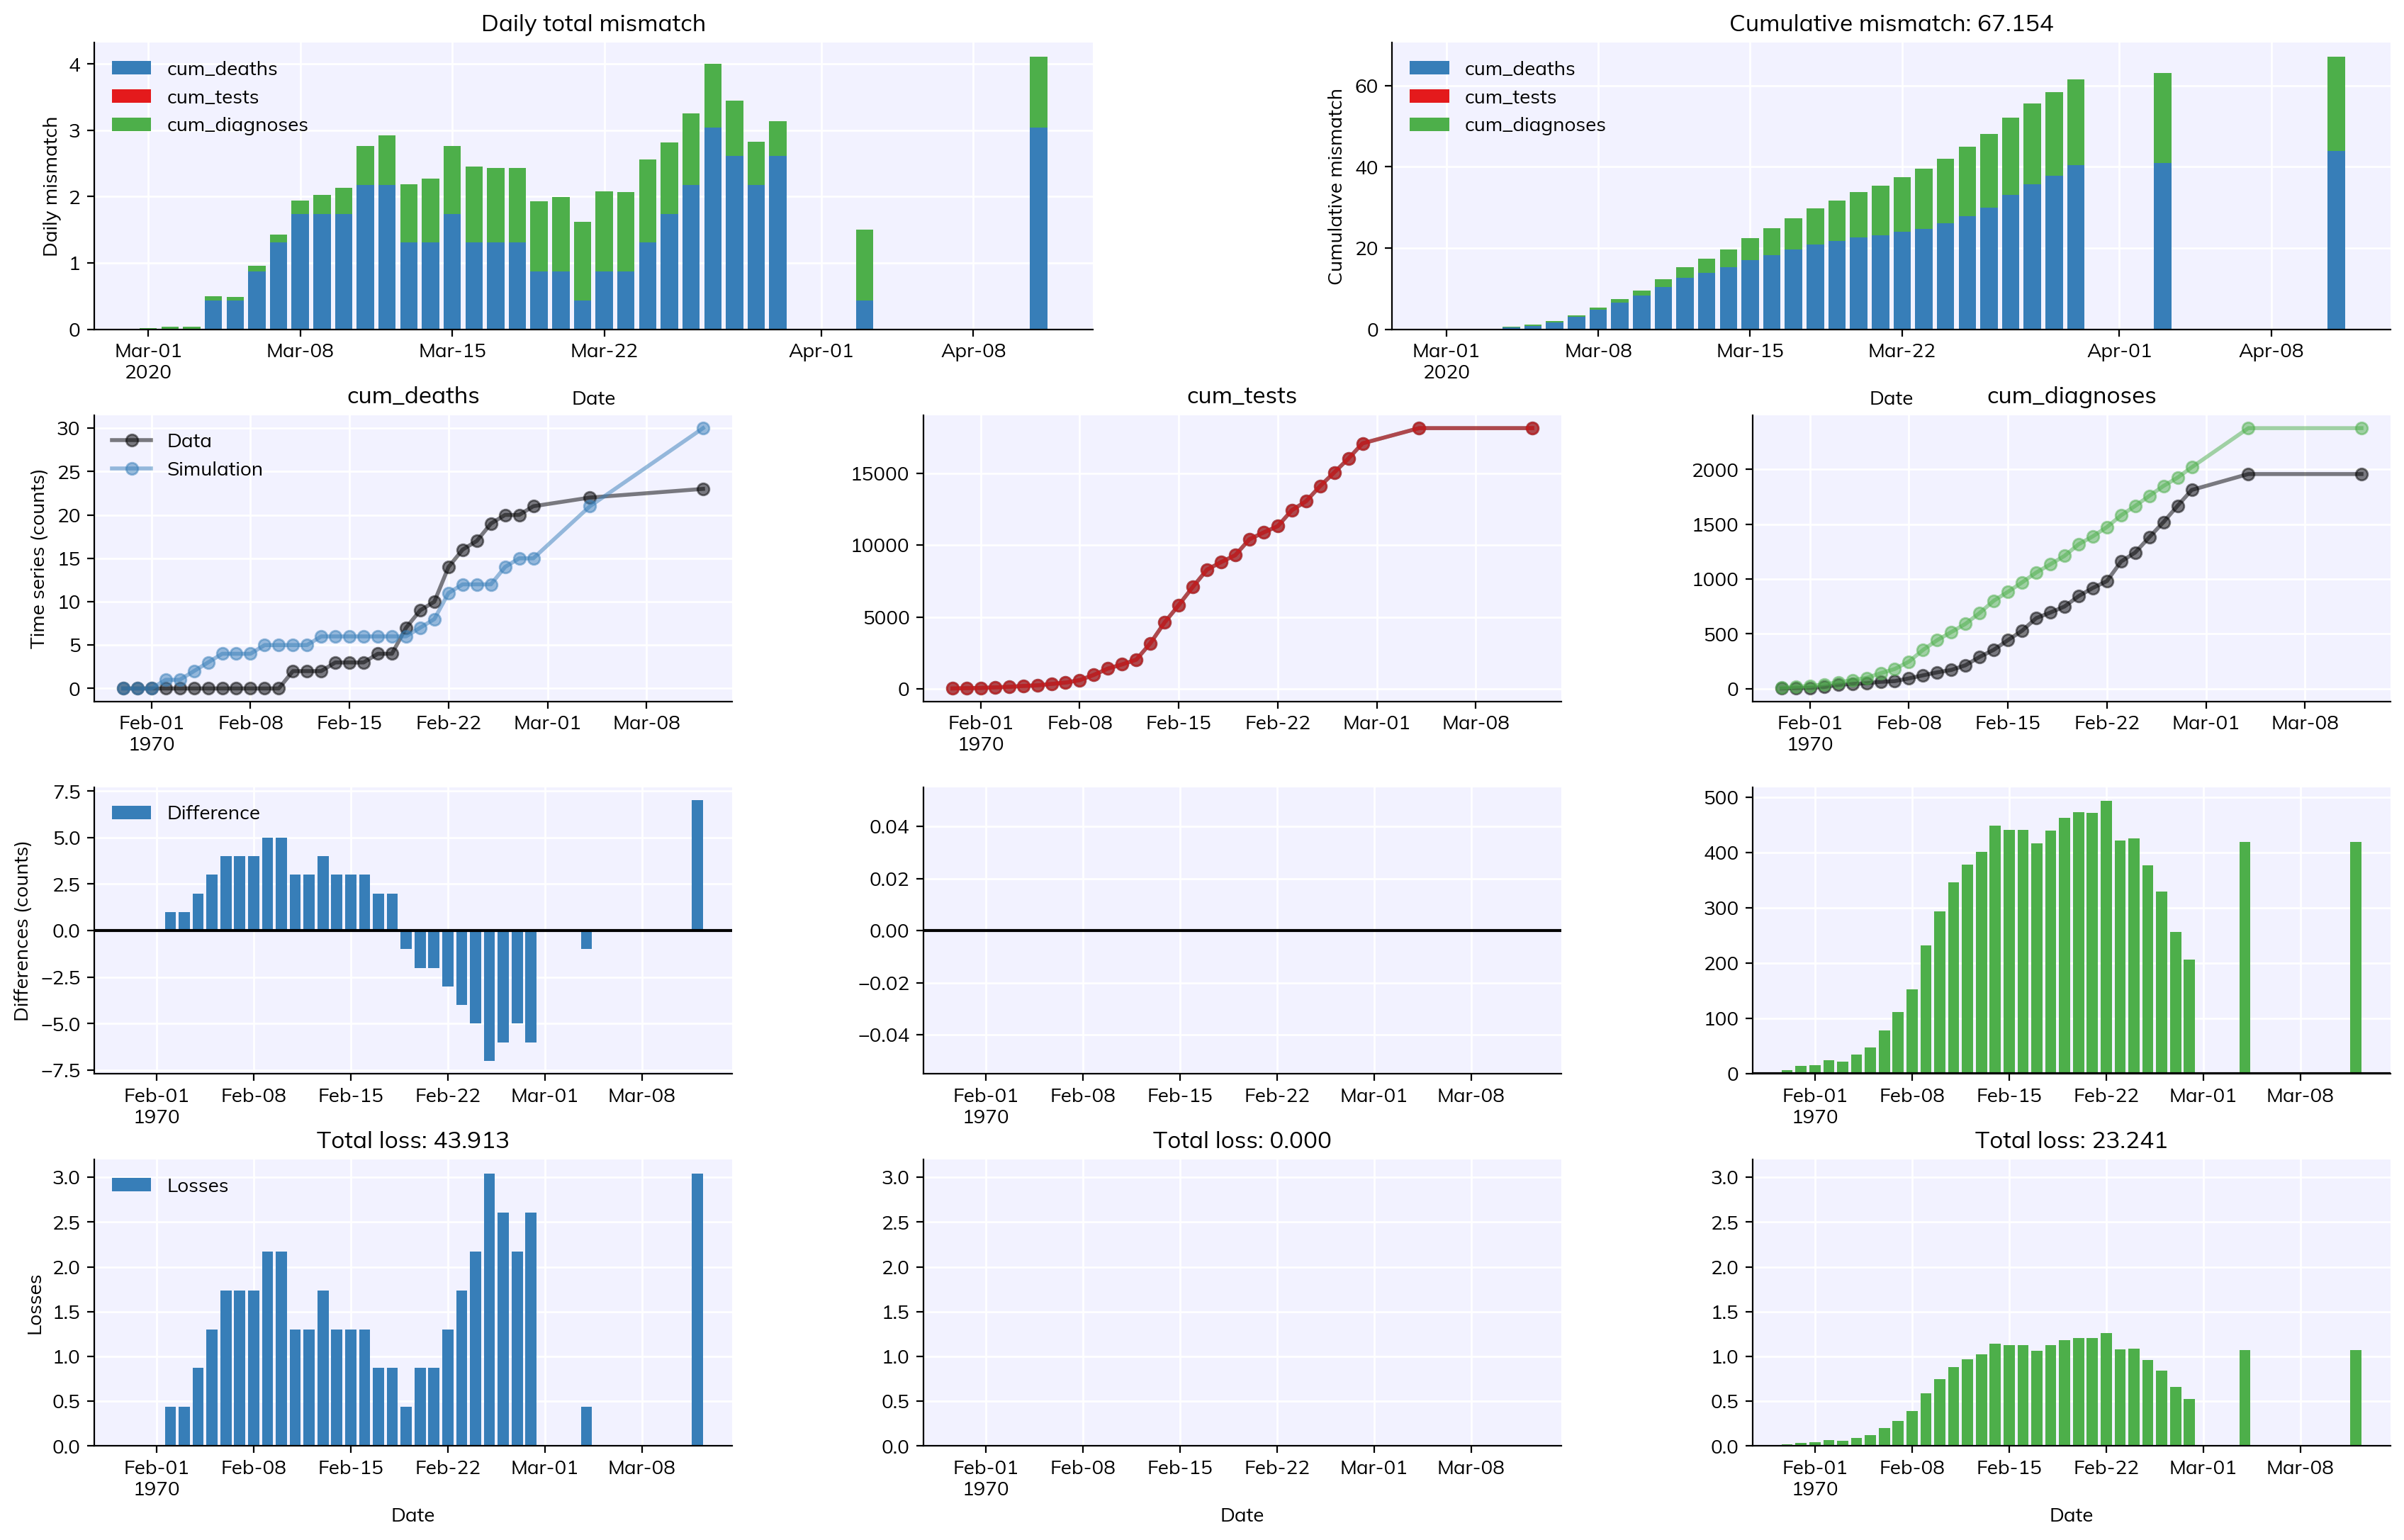

Mismatch values for:
#0. 'cum_deaths':    43.913043478260875
#1. 'cum_tests':     0.0
#2. 'cum_diagnoses': 23.240551583248212

Total mismatch value:
67.1535950615091


In [5]:
fit.plot()
fit.summarize()

As expected, the fit is slightly improved. By now, you may be wondering how the mistmatch is actually calculated in Covasim. It follows more or less this expression: 

$\text{mismatch} = \sum_i\left(\sum_t\dfrac{|d_i(t) - m_i(t)|}{\text{max}(d_i(t))}\right)$

where $i$ is over different data quantities (eg, `cum_tests`, `cum_deaths`, `cum_diagnoses` in this example); $t$ is time; $d_i(t)$ is the time series of data for quantity $i$ (the lines with square markers in the figures); and, $m_i(t)$ is the time series of the model for quantity $i$ (solid lines). 

Each data quantity $i$ has very different scales. Cumulative deaths could be in the few hundreds, while cumulative diagnoses could be in the tens of thousands (or more). For that reason we use the term $\text{max}(d_i(t))$, so we can reasonably add individual mismatches of different quantities like cumulative deaths and diagnoses, to produce an overall mismatch, which is a 'normalized' absolute error of sorts. 

## Calibration approaches

Calibration is a complex and dark art and cannot be covered fully here; many books have been written about it and it continues to be an area of active research. A good review article about calibrating agent-based models like Covasim is available [here](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007893). Calibration is usually expressed as an optimization problem: specifically, find a vector of parameters *θ* that minimizes the mismatch between the data *D* and the model *M(θ)*.

In practice, most calibration is done simply by hand, as in the example above. Once deaths are "calibrated", the user might modify testing assumptions so that the diagnoses match. Since we are only fitting to deaths and diagnoses, the model is then "calibrated".

However, automated approaches to calibration are possible as well. The simplest is probably the built-in SciPy optimization functions, e.g. `scipy.optimize`. A wrinkle here is that normal gradient descent methods **will not work** with Covasim or other agent-based models, due to the stochastic variability between model runs that makes the landscape very "bumpy". One way of getting around this is to use many different runs and take the average, e.g.:

```python
import covasim as cv
import numpy as np
from scipy import optimize

def objective(x, n_runs=10):
    print(f'Running sim for beta={x[0]}, rel_death_prob={x[1]}')
    pars = dict(
        pop_size       = 20_000,
        start_day      = '2020-02-01',
        end_day        = '2020-04-11',
        beta           = x[0],
        rel_death_prob = x[1],
        verbose        = 0,
    )
    sim = cv.Sim(pars=pars, datafile='example_data.csv', interventions=cv.test_num(daily_tests='data'))
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    mismatches = []
    for sim in msim.sims:
        fit = sim.compute_fit()
        mismatches.append(fit.mismatch)
    mismatch = np.mean(mismatches)
    return mismatch

guess = [0.015, 1] # Initial guess of parameters -- beta and relative death probability
pars = optimize.minimize(objective, x0=guess, method='nelder-mead') # Run the optimization
```

This should converge after roughly 3-10 minutes, although you will likely find that the improvement is minimal.

What's happening here? Trying to overcome the limitations of an algorithm that expects deterministic results simply by running more sims is fairly futile – if you run *N* sims and average them together, you've only reduced noise by √*N*, i.e. you have to average together 100 sims to reduce noise by a factor of 10, and even that might not be enough. Clearly, we need a more powerful approach.

## Built-in calibration

One such package we have found works reasonably well is called [Optuna](https://optuna.org/). It is built into Covasim as `sim.calibrate()` (it's not installed by default, so please install it first with `pip install optuna`). Do not expect this to be a magic bullet solution: you will likely still need to try out multiple different parameter sets for calibration, manually update the values of uncalibrated parameters, check if the data actually make sense, etc. Even once all these things are in place, it still needs to be run for enough iterations, which might be a few hundred iterations for 3-4 calibrated (free) parameters or tens of thousands of iterations for 10 or more free parameters. The example below should get you started, but best to expect that it will _not_ work for your particular use case without significant modification!

In [8]:
'''
Example for running built-in calibration with Optuna
'''

import sciris as sc
import covasim as cv

# Create default simulation
pars = sc.objdict(
    pop_size       = 20_000,
    start_day      = '2020-02-01',
    end_day        = '2020-04-11',
    beta           = 0.015,
    rel_death_prob = 1.0,
    interventions  = cv.test_num(daily_tests='data'),
    verbose        = 0,
)
sim = cv.Sim(pars=pars, datafile='example_data.csv')

# Parameters to calibrate -- format is best, low, high
calib_pars = dict(
    beta           = [pars.beta, 0.005, 0.20],
    rel_death_prob = [pars.rel_death_prob, 0.5, 3.0],
)

if __name__ == '__main__':

    # Run the calibration
    calib = sim.calibrate(calib_pars=calib_pars, total_trials=100)

[I 2023-09-26 10:19:37,735] A new study created in RDB with name: covasim_calibration


Could not delete study, skipping...
'Record does not exist.'
Removed existing calibration covasim_calibration.db


[I 2023-09-26 10:19:39,268] Trial 1 finished with value: 231.37385086823292 and parameters: {'beta': 0.07378680600387472, 'rel_death_prob': 0.6394865177164684}. Best is trial 1 with value: 231.37385086823292.
[I 2023-09-26 10:19:39,267] Trial 3 finished with value: 235.0 and parameters: {'beta': 0.0771118379791899, 'rel_death_prob': 1.7150956442159804}. Best is trial 1 with value: 231.37385086823292.
[I 2023-09-26 10:19:39,278] Trial 2 finished with value: 236.28447395301328 and parameters: {'beta': 0.07450195816838837, 'rel_death_prob': 1.288944061207044}. Best is trial 1 with value: 231.37385086823292.
[I 2023-09-26 10:19:39,326] Trial 0 finished with value: 243.6644535240041 and parameters: {'beta': 0.10915505995313937, 'rel_death_prob': 0.9871029397101329}. Best is trial 1 with value: 231.37385086823292.
[I 2023-09-26 10:19:39,381] Trial 6 finished with value: 241.6292134831461 and parameters: {'beta': 0.056384102125863006, 'rel_death_prob': 2.135074001412282}. Best is trial 1 with

[I 2023-09-26 10:19:42,377] Trial 40 finished with value: 327.2522982635342 and parameters: {'beta': 0.03225506317766355, 'rel_death_prob': 0.8111656312559772}. Best is trial 23 with value: 16.501532175689476.
[I 2023-09-26 10:19:42,456] Trial 41 finished with value: 334.6527068437181 and parameters: {'beta': 0.03486280488282452, 'rel_death_prob': 0.8746109747834977}. Best is trial 23 with value: 16.501532175689476.
[I 2023-09-26 10:19:42,459] Trial 42 finished with value: 334.8927477017365 and parameters: {'beta': 0.03428359089329015, 'rel_death_prob': 0.8709477422318088}. Best is trial 23 with value: 16.501532175689476.
[I 2023-09-26 10:19:42,472] Trial 43 finished with value: 349.33605720122574 and parameters: {'beta': 0.030340525829955074, 'rel_death_prob': 0.7882163831106713}. Best is trial 23 with value: 16.501532175689476.
[I 2023-09-26 10:19:42,598] Trial 46 finished with value: 334.8697650663943 and parameters: {'beta': 0.036546051737585725, 'rel_death_prob': 0.805601791310172

[I 2023-09-26 10:19:45,597] Trial 79 finished with value: 14.591419816138917 and parameters: {'beta': 0.013556367038629114, 'rel_death_prob': 1.0196052977438346}. Best is trial 68 with value: 11.598569969356486.
[I 2023-09-26 10:19:45,603] Trial 78 finished with value: 32.425944841675175 and parameters: {'beta': 0.012102349106239809, 'rel_death_prob': 0.5461448246353919}. Best is trial 68 with value: 11.598569969356486.
[I 2023-09-26 10:19:45,630] Trial 80 finished with value: 39.11644535240041 and parameters: {'beta': 0.011880065203839916, 'rel_death_prob': 1.0360422037026247}. Best is trial 68 with value: 11.598569969356486.
[I 2023-09-26 10:19:45,634] Trial 81 finished with value: 16.108273748723185 and parameters: {'beta': 0.013209644464126776, 'rel_death_prob': 0.5285331656840804}. Best is trial 68 with value: 11.598569969356486.
[I 2023-09-26 10:19:45,776] Trial 83 finished with value: 17.584269662921347 and parameters: {'beta': 0.013060777840521615, 'rel_death_prob': 0.508897217

Making results structure...
Processed 108 trials; 0 failed
Deleted study covasim_calibration in sqlite:///covasim_calibration.db
Removed existing calibration covasim_calibration.db
Calibration for 108 total trials completed in 10.1 s.

Initial parameter values:
#0. 'beta':           0.015
#1. 'rel_death_prob': 1.0

Best parameter values:
#0. 'beta':           0.014604259691170445
#1. 'rel_death_prob': 0.5889938785826332

Mismatch before calibration: 16.6828
Mismatch after calibration:  11.5986
Percent improvement:         30.5%


So it improved the fit (see above), but let's visualize this as a plot:

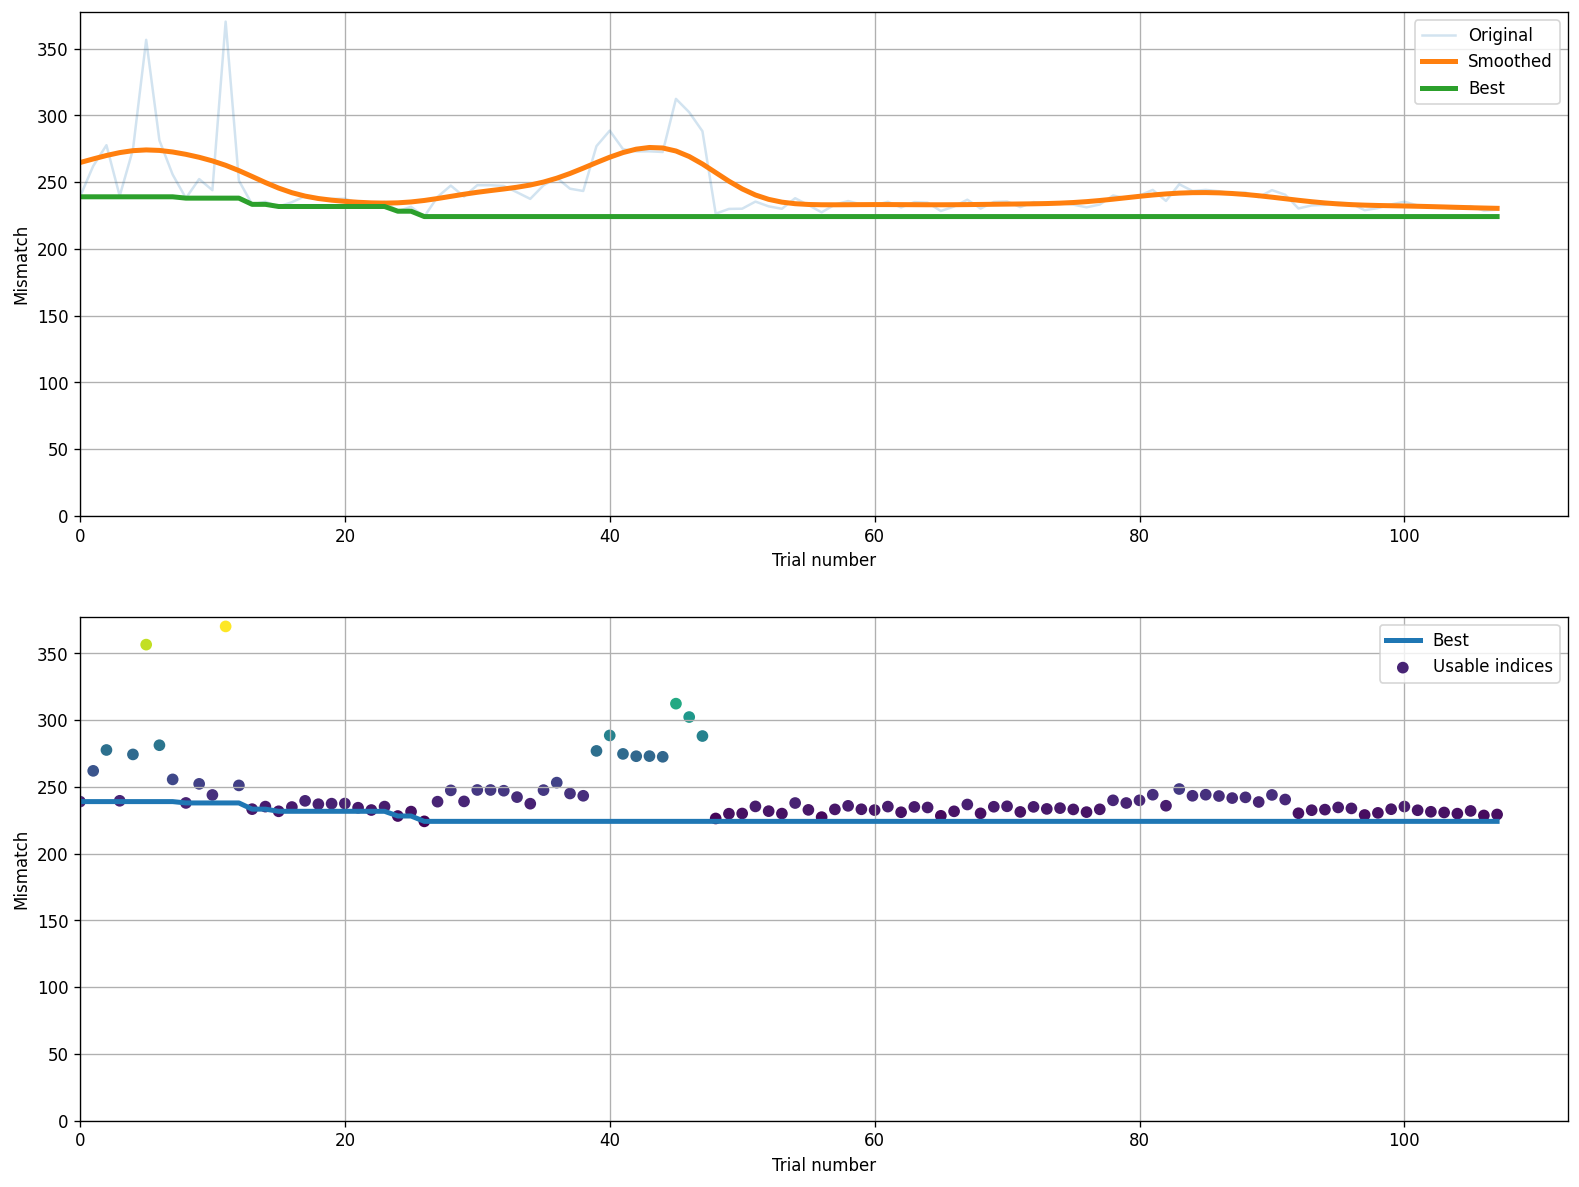

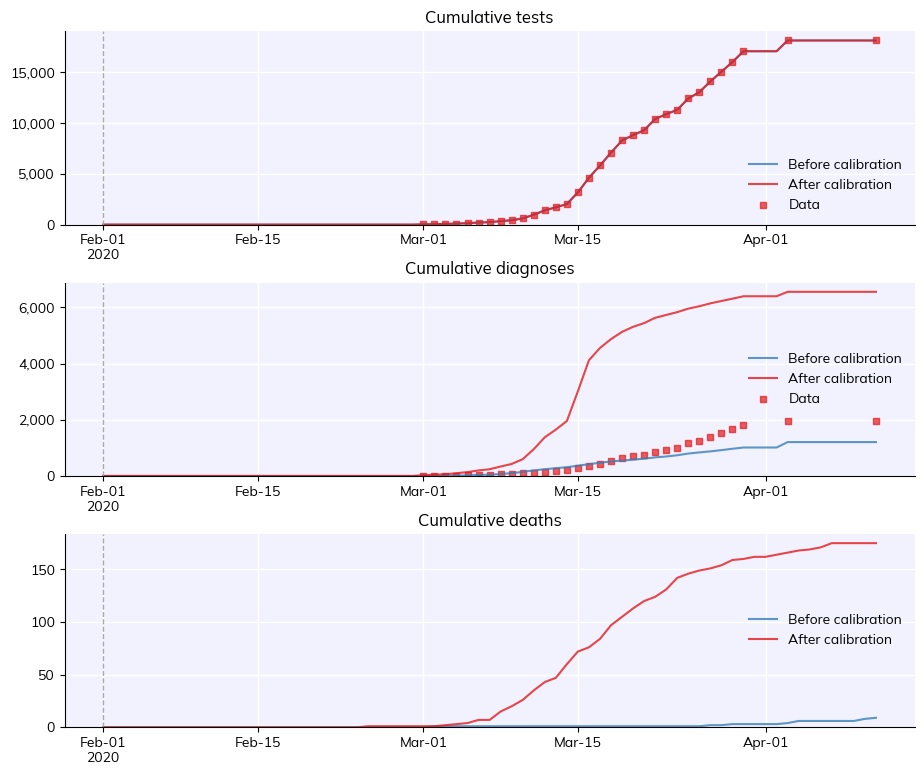

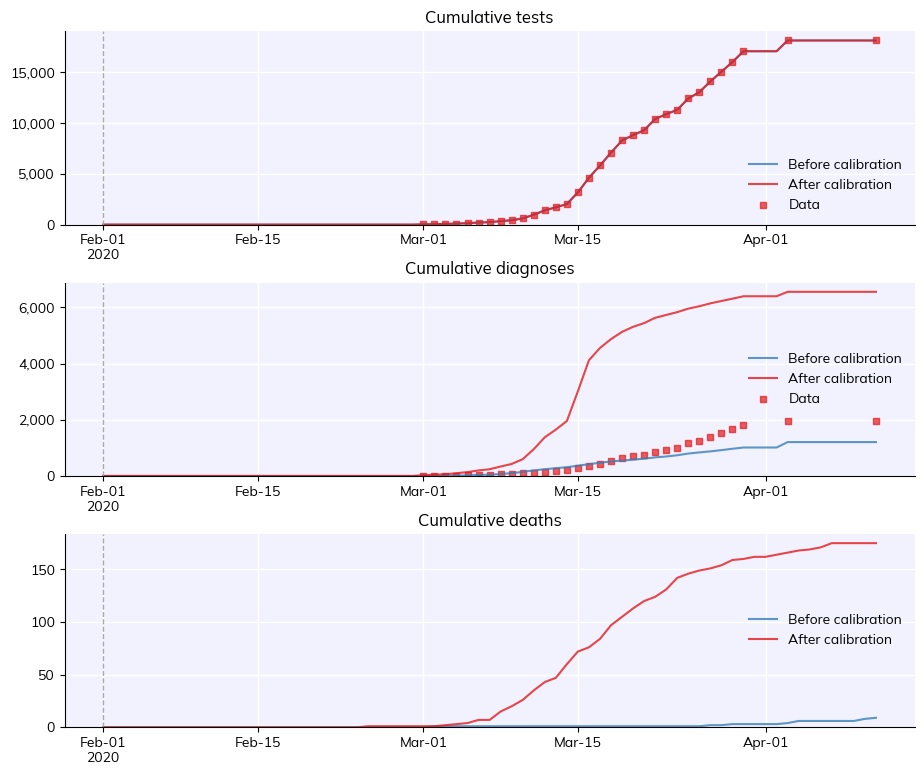

In [2]:
# Plot the results
calib.plot_trend()
calib.plot_sims(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths'])

Compared to `scipy.optimize.minimize()`, Optuna took less time and produced a better fit. Specifically, the  mismatch obtained with Optuna is almost half the smallest mismatch achieved with `scipy.optimize`. However, Optuna's results are still far from perfect -- running calibration runs, or more iterations, and calibrating more parameters beyond just these two, would still be required before the model could be considered "calibrated".

Sometimes you want to calibrate a parameter that isn't a built-in parameter -- for example, part of an intervention. You can do this using the `custom_fn` keyword argument. In this example, we calibrate the test probability by modifying the `test_prob` intervention directly.

[I 2023-09-26 10:21:59,066] A new study created in RDB with name: covasim_calibration


Could not delete study, skipping...
'Record does not exist.'
Removed existing calibration covasim_calibration.db


[I 2023-09-26 10:21:59,510] Trial 6 finished with value: 53.58594582553735 and parameters: {'beta': 0.007858743675823078, 'test_prob': 0.18599323974728035}. Best is trial 2 with value: 50.0537251024126.
[I 2023-09-26 10:21:59,511] Trial 4 finished with value: 53.23941098247942 and parameters: {'beta': 0.008990634443968533, 'test_prob': 0.19292488836064411}. Best is trial 2 with value: 50.0537251024126.
[I 2023-09-26 10:21:59,519] Trial 0 finished with value: 29.766372918009417 and parameters: {'beta': 0.01581216660555194, 'test_prob': 0.14543842582858824}. Best is trial 0 with value: 29.766372918009417.
[I 2023-09-26 10:21:59,521] Trial 2 finished with value: 50.0537251024126 and parameters: {'beta': 0.008843810326313834, 'test_prob': 0.10787144106718295}. Best is trial 0 with value: 29.766372918009417.
[I 2023-09-26 10:21:59,573] Trial 3 finished with value: 36.4094237571735 and parameters: {'beta': 0.014234675870938927, 'test_prob': 0.1106297013998878}. Best is trial 0 with value: 29

[I 2023-09-26 10:22:00,415] Trial 40 finished with value: 25.489573392746518 and parameters: {'beta': 0.01732188041777959, 'test_prob': 0.29847643998145984}. Best is trial 19 with value: 24.93833144385554.
[I 2023-09-26 10:22:00,470] Trial 41 finished with value: 48.18262999235314 and parameters: {'beta': 0.016498809075581745, 'test_prob': 0.27871910979812603}. Best is trial 19 with value: 24.93833144385554.
[I 2023-09-26 10:22:00,506] Trial 42 finished with value: 26.36391098409942 and parameters: {'beta': 0.016859608609219947, 'test_prob': 0.2687981223452336}. Best is trial 19 with value: 24.93833144385554.
[I 2023-09-26 10:22:00,520] Trial 45 finished with value: 37.180428644278265 and parameters: {'beta': 0.015379108689554428, 'test_prob': 0.2724477765039188}. Best is trial 19 with value: 24.93833144385554.
[I 2023-09-26 10:22:00,520] Trial 43 finished with value: 25.676524133372347 and parameters: {'beta': 0.01669254423590408, 'test_prob': 0.27376273284605507}. Best is trial 19 wi

Making results structure...
Processed 60 trials; 0 failed
Deleted study covasim_calibration in sqlite:///covasim_calibration.db
Removed existing calibration covasim_calibration.db
Calibration for 60 total trials completed in 2.0 s.

Initial parameter values:
#0. 'beta':      0.013
#1. 'test_prob': 0.01

Best parameter values:
#0. 'beta':      0.018642633327436764
#1. 'test_prob': 0.2761730385438621

Mismatch before calibration: 53.771
Mismatch after calibration:  23.6653
Percent improvement:         56.0%


/home/ranga519/anaconda3/envs/abm_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ranga519/anaconda3/envs/abm_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ranga519/anaconda3/envs/abm_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ranga519/anaconda3/envs/abm_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

/home/ranga519/ABM-covasim/covasim/analysis.py:1756: UserWarning: The figure layout has changed to tight
  grid.fig.tight_layout()


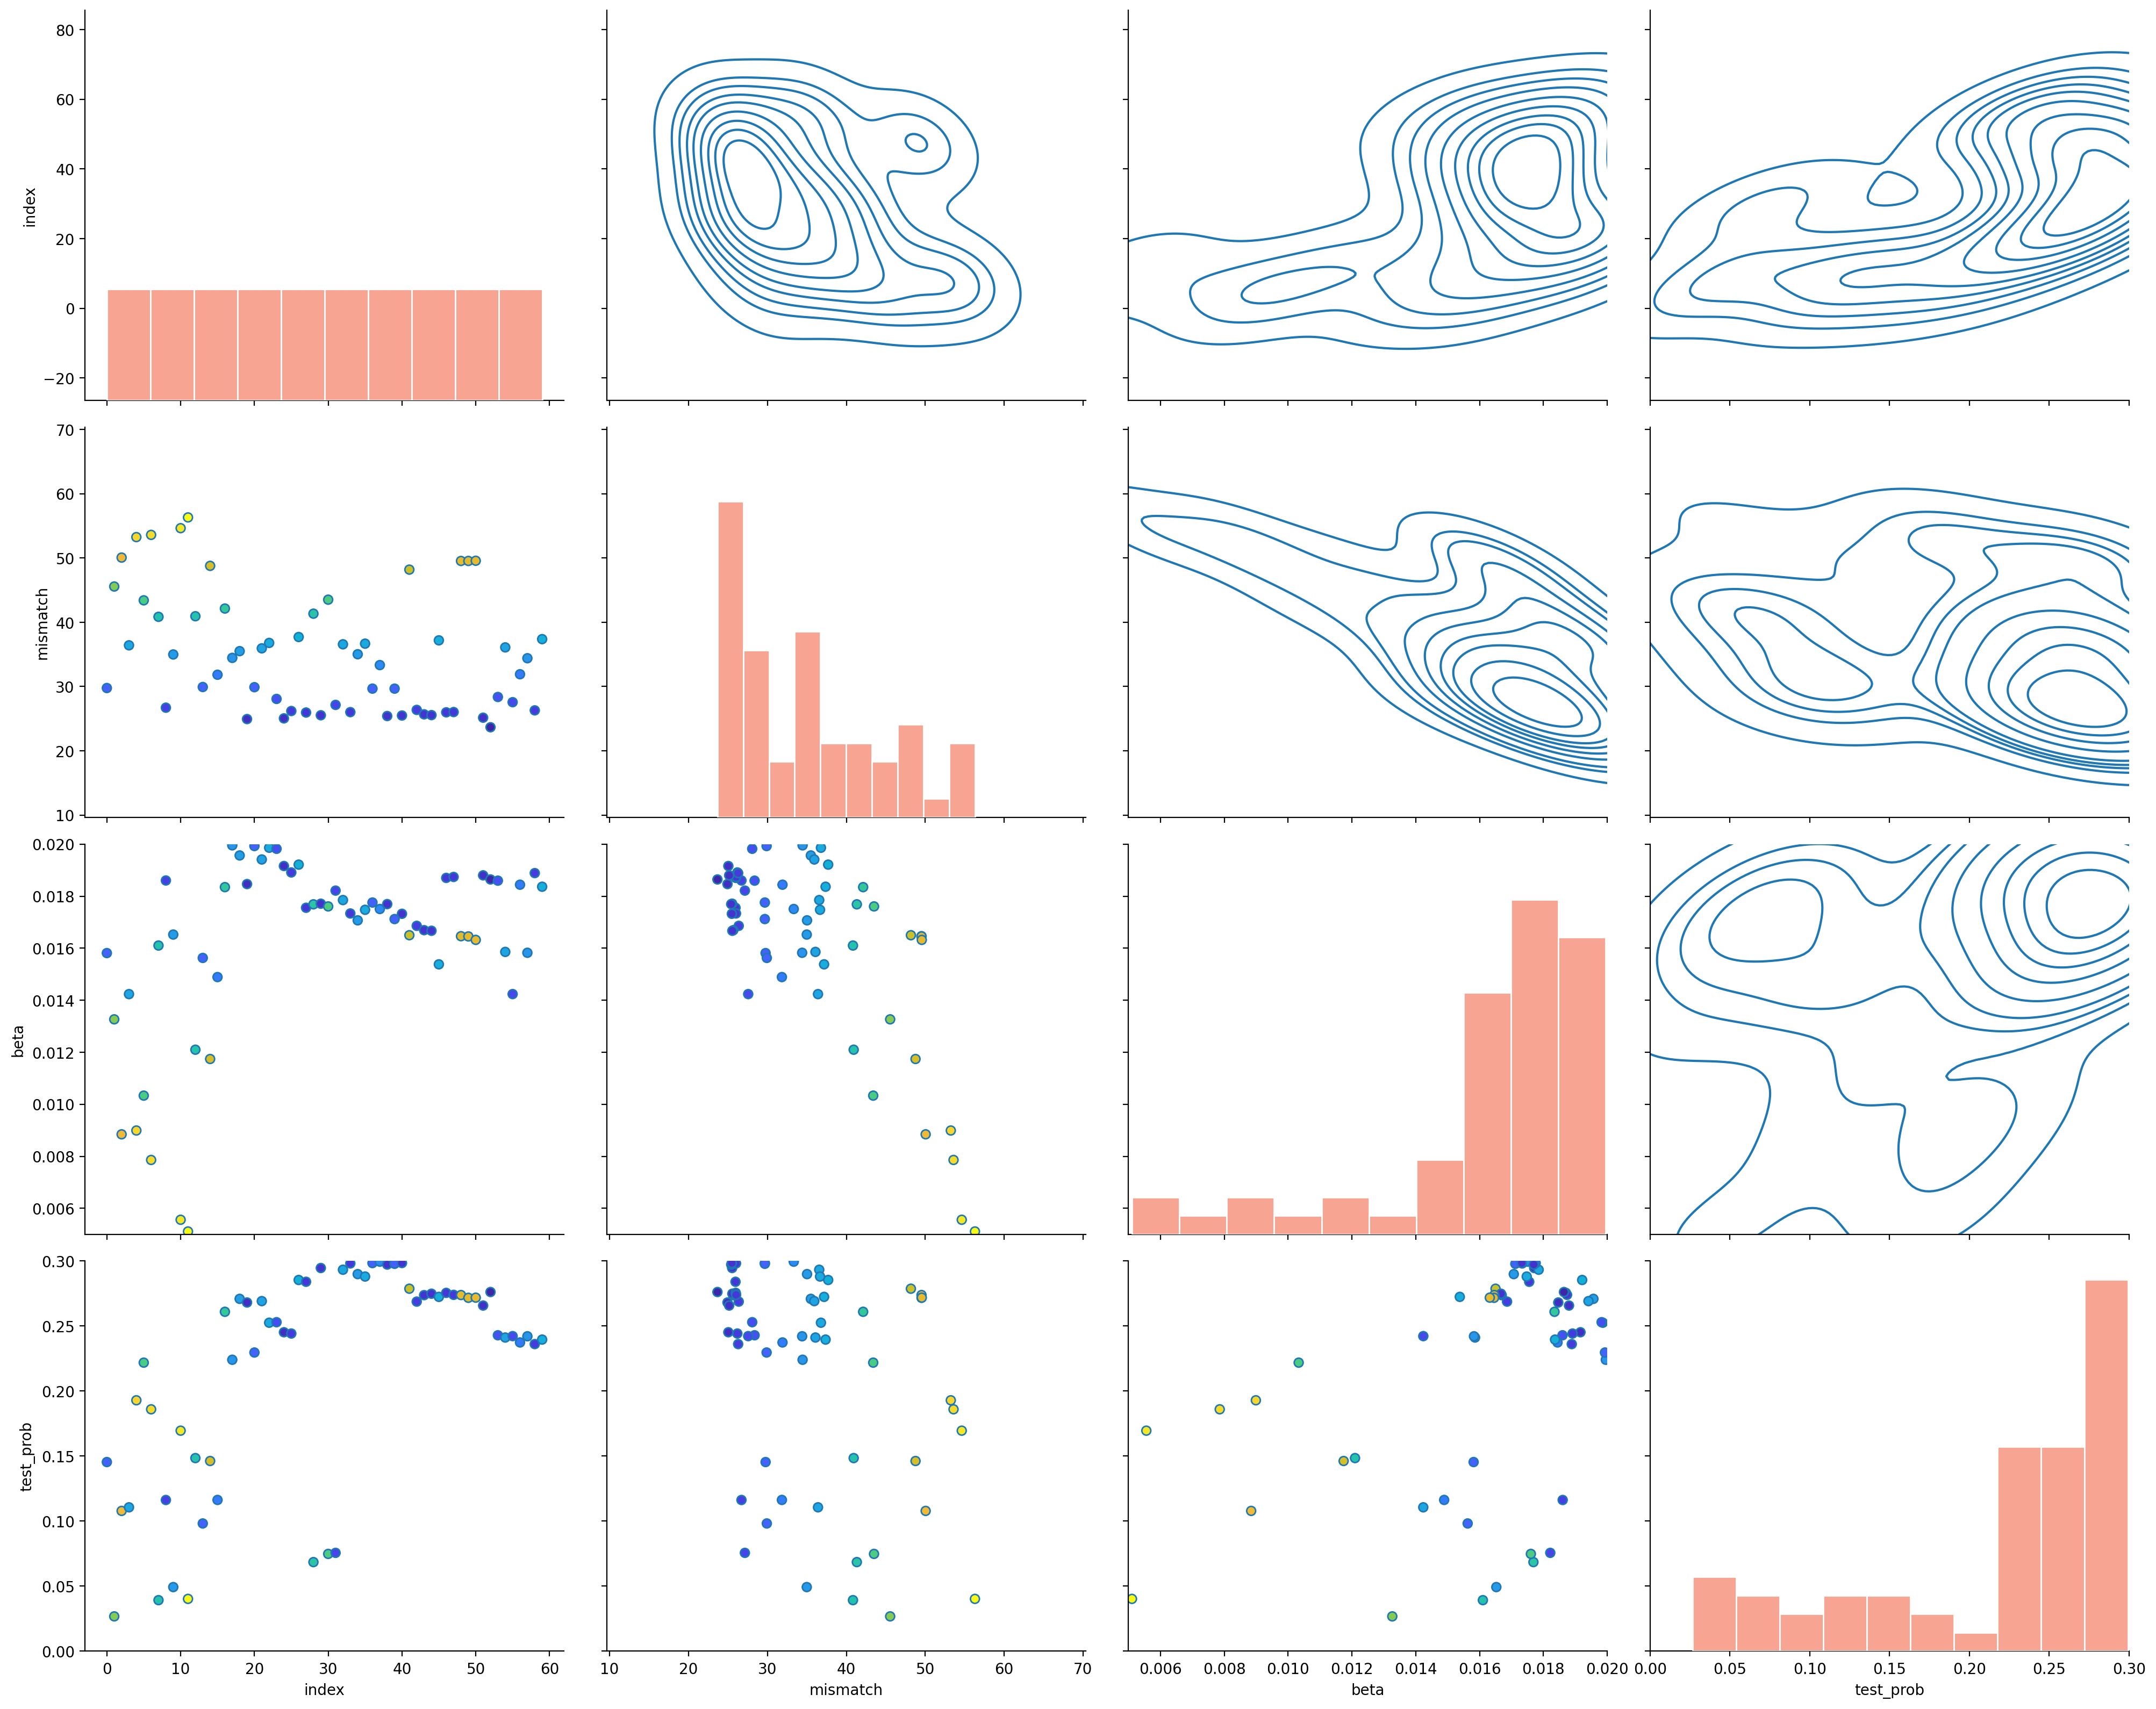

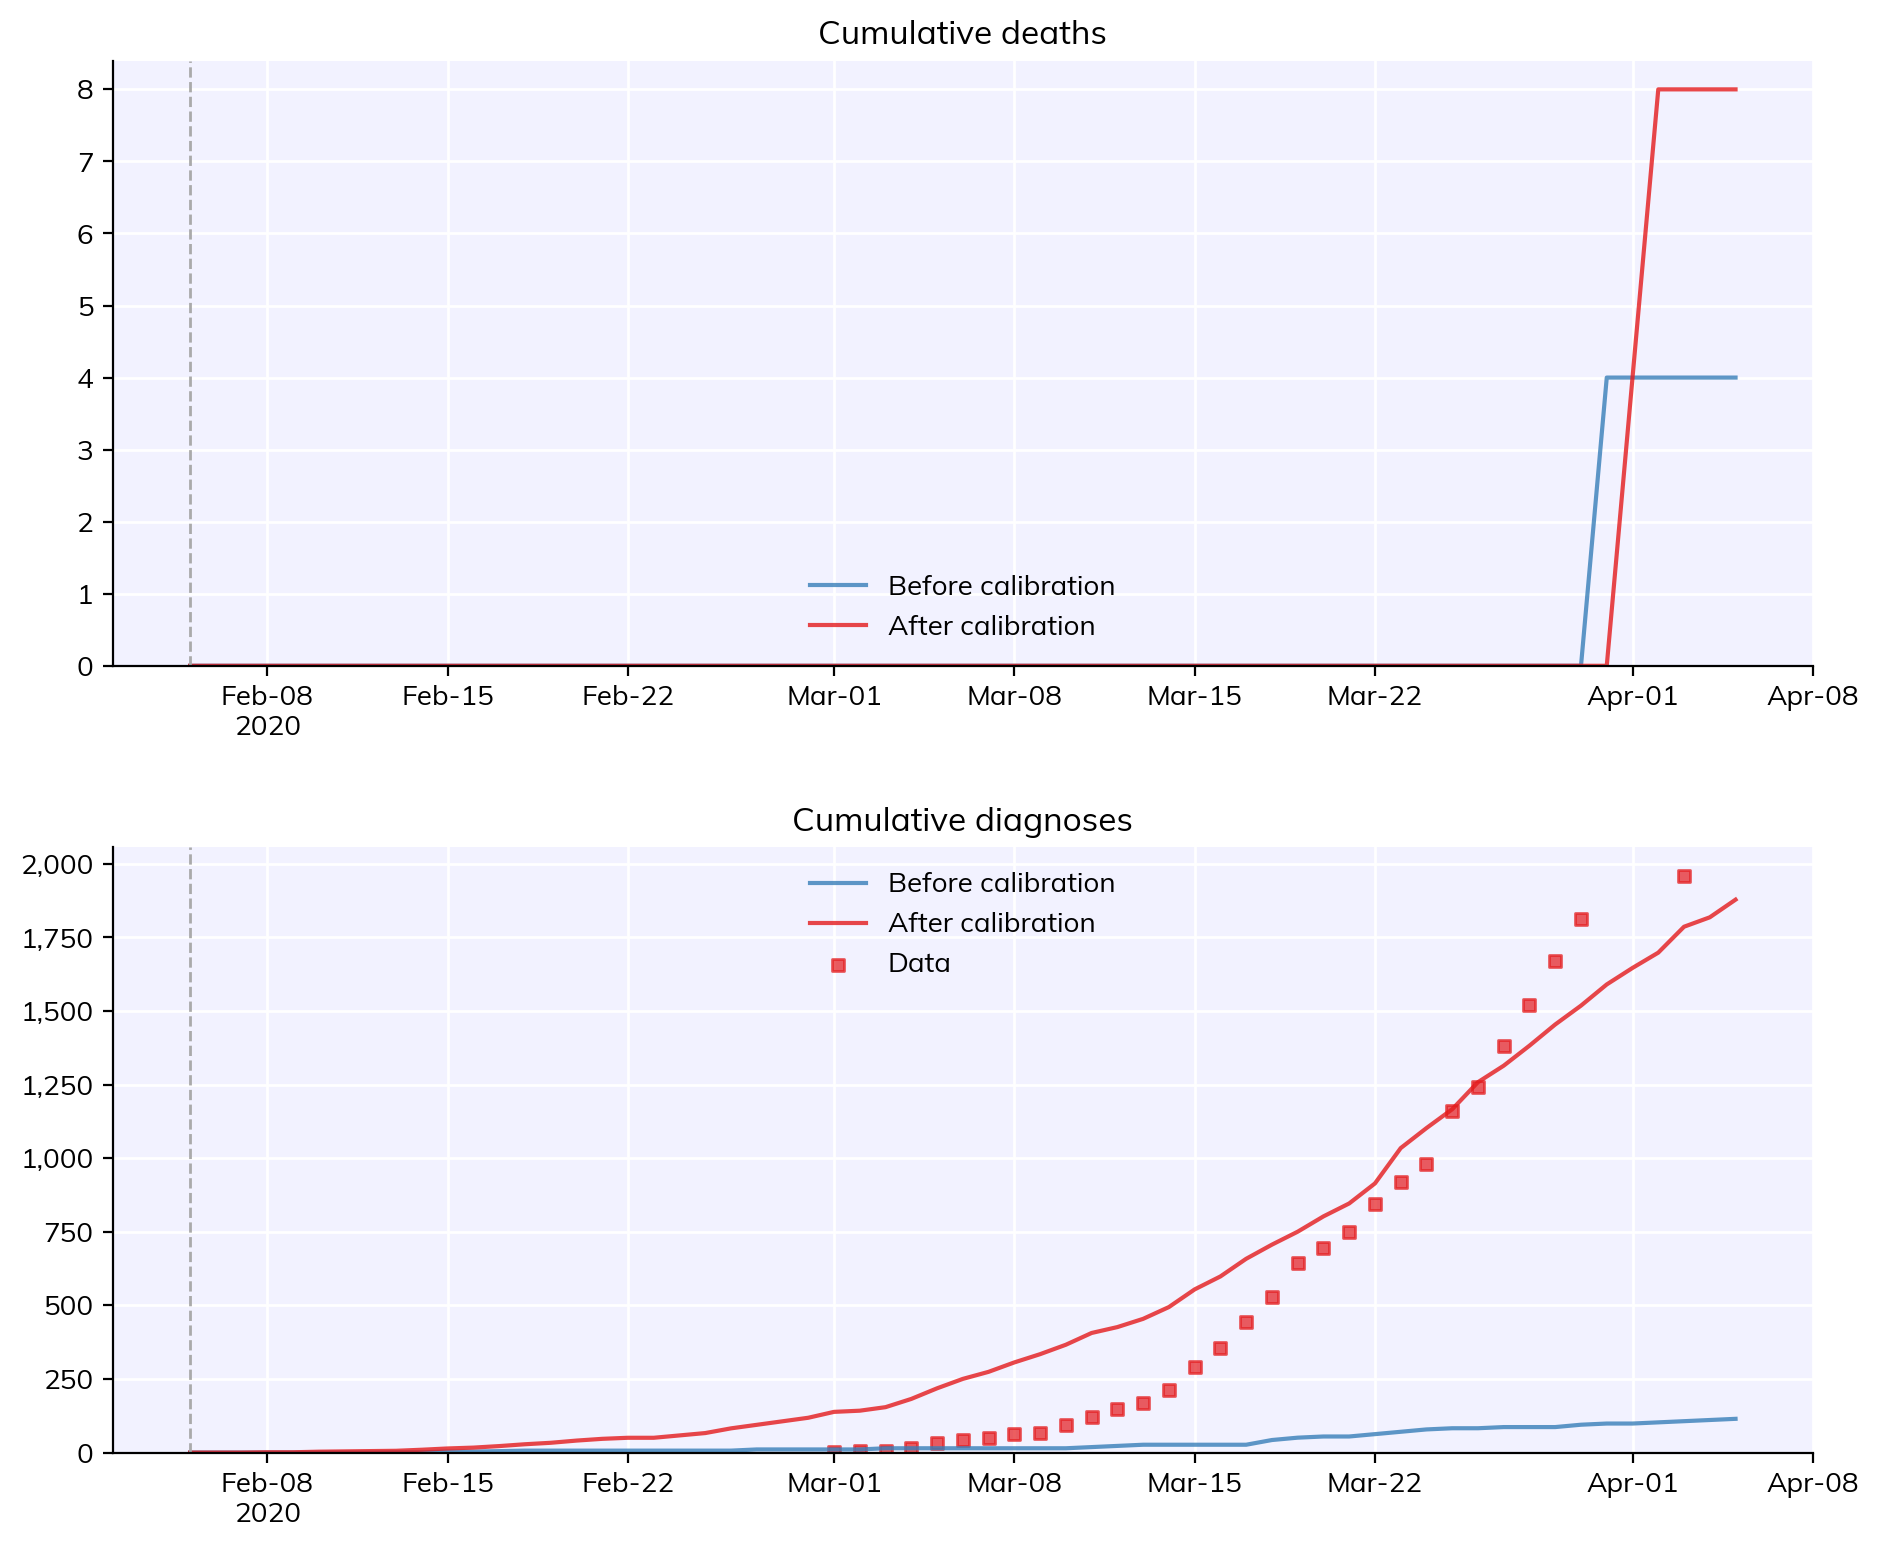

In [9]:
pars = dict(
    verbose = 0,
    start_day = '2020-02-05',
    pop_size = 1000,
    pop_scale = 4,
    interventions = cv.test_prob(symp_prob=0.01),
)

sim = cv.Sim(pars, datafile='example_data.csv')

calib_pars = dict(
    beta      = [0.013, 0.005, 0.020],
    test_prob = [0.01, 0.00, 0.30]
)

def set_test_prob(sim, calib_pars):
    tp = sim.get_intervention(cv.test_prob)
    tp.symp_prob = calib_pars['test_prob']
    return sim

calib = sim.calibrate(calib_pars=calib_pars, custom_fn=set_test_prob, total_trials=60)
calib.plot_all()
calib.plot_sims(to_plot=['cum_deaths', 'cum_diagnoses'])